In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()
using Test
using Plots
include("quadruped.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7619906604085283333\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10750386391638795375\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7619906604085283333\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

 Activating environment at `C:\Users\Administrator\Documents\GitHub\16-745-hw2\Project.toml`


run_tests (generic function with 1 method)

# Q1: Balancing the Quadruped with LQR (25 pts)
In this problem you'll stabilize the quadruped around the equilibrium point you found in the previous homework.

Note that we modified the model a little from the previous HW to make this problem easier. It now has once less degree of freedom (DOF), since we aren't allowing it to twist on the floor. Assuming we have "grippy" rubber feet, this isn't a bad assumption to make. This means it now has 28 states (14 positions, 14 velocities) and 12 controls.

In [2]:
# Load the quadruped model
model = UnitreeA1()
n,m = state_dim(model), control_dim(model)
dt = 0.01

# Use the equilibrium point we found in HW1
xeq = [0.30876598892362367, -0.260133570638461, -0.09358998727238592, 0.7078311865326717, -0.41038927424745475, -0.3598290230260733, 0.35837932714316556, 0.3579443729935737, -0.52325974352618, -0.524349602250509, 0.5321637004468419, 0.17483502352564967, 0.1745288580720117, -0.17241139464042135, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ueq = [7.326746743908579, 12.492831761746691, -3.7276131797642345, -0.21210770886642585, 0.7228048164769122, 0.7061868479839222, -0.954088911642226, -0.8136046730618279, -0.5649940436402389, -0.273344715530589, -0.2382444936066465, -0.19338784324481662]

# Evaluate the continuous-time Jacobian
∇f = jacobian(model, xeq, ueq)
A = ∇f.A
B = ∇f.B

# Evaluate the discrete-time Jacobian
∇f = discrete_jacobian(RK4, model, xeq, ueq, dt)
A = ∇f.A
B = ∇f.B

28×12 view(::Array{Float64,2}, :, 29:40) with eltype Float64:
 -0.00501761    0.00275857    0.000395093  -0.000490889  …  -0.000624811  -9.94028e-5    0.000323178   0.000420569
  0.000485075  -0.000265282  -0.000118496  -6.06853e-5       5.52825e-5    8.13007e-6   -1.32382e-5   -4.76284e-5
  0.0106638    -0.00601708   -0.000715189   0.00115071       0.00116469    0.000322573  -0.000589022  -0.000794039
 -0.00601708    0.0036206     0.00047001   -0.000486699     -0.000454186  -0.000360263   0.000257854   0.000350132
 -0.000715189   0.00047001    0.00157014    0.00166441       0.000149207  -9.2619e-5     0.000210018  -0.000157996
  0.00115071   -0.000486699   0.00166441    0.0036878    …   0.000435931   0.000180723   7.40781e-5   -0.000313993
  0.000810738  -0.000521531   0.00156741    0.00183711       0.000275984   6.58689e-5   -0.000121195  -0.000319907
 -0.000167801   0.000301072   0.00183543    0.00208474       3.79155e-5   -0.00018884    0.000197402   0.000123055
 -0.000558246   0.0

## Part (a): Compute the optimal LQR gains using Riccati (8 pts)
As we saw in class, we can solve the LQR problem using a backward Riccati recursion, which also generates a locally-optimal feedback controller. Implement your own method to calculate a set of optimal feedback gains.

In [3]:
# TASK: Implement the following function (5 pts)
"""
    riccati(A,B,Q,R,Qf,N)

Use backward riccati recursion to solve the finite-horizon time-invariant LQR problem.
Returns vectors of the feedback gains `K` and cost-to-go matrices `P`, where `length(K) == N-1`,
`length(P) == N`, and `size(K[i]) == (m,n)` and `size(P[i]) == (n,n)`.

# Arguments:
* `A`: `(n,n)` discrete dynamics Jacobian wrt the state
* `B`: `(n,m)` discrete dynamics Jacobian wrt the control
* `Q`: `(n,n)` stage-wise cost matrix for states
* `R`: `(m,m)` stage-wise cost matrix for controls
* `Qf`: `(n,n)` cost matrix for terminal state
* `N`: Integer number of time steps (horizon length).
"""
function riccati(A,B,Q,R,Qf,N)
    # initialize the output
    n,m = size(B)
    P = [zeros(n,n) for k = 1:N]
    K = [zeros(m,n) for k = 1:N-1]
    
    # TODO: implement the Riccati recursion
    P[N] = Qf
    for i=N-1:-1:1
        K[i] .= (R + B'*P[i+1]*B)\(B'*P[i+1]*A)
#         P[i] .= Q + K[i]'*R*K[i] + (A-B*K[i])'*P[i+1]*(A-B*K[i])
        P[i] .= Q + A'*P[i+1]*A - A'*P[i+1]*B*K[i]
    end
    # return the feedback gains and ctg matrices
    return K,P
end

riccati

In [4]:
# TASK: Compute the optimal gains (3 pts)
#       Store the result in a matrix K::Vector{Matrix{Float64}}, where size(K[1]) = (12,28)
#       Use the cost matrices provided below

# Some parameters
dt = 0.01
tf = 2.0
times = range(0,tf,step=dt)
N = length(times)

# Define the LQR cost
Q = Diagonal([fill(130.,n÷2); fill(130.,n÷2)])
R = Diagonal(fill(10.0, m))
Qf = copy(Q)

# TODO: solve for the feedback gains
A = zeros(n,n)
B = zeros(n,m)
∇f = discrete_jacobian(RK4, model, xeq, ueq, dt)
A = ∇f.A
B = ∇f.B 
K,P = riccati(A,B,Q,R,Qf,N);

In [5]:
# using Test
# using FileIO
# xtest = xeq + randn(28)*0.1
# data = load(joinpath(@__DIR__, "../test/q1.jld2"))

# # Part a
# K1 = data["K1"] 
# P1 = data["P1"] 
# @test length(K) == 200
# @test size(K[1]) == (12,28)
# @test size(P[1]) == (28,28)
# @test K[1] ≈ K1 rtol = 1e-4
# @test P[1] ≈ P1 rtol = 1e-4
# @test norm(K[1],Inf) >  norm(K[end],Inf)

## Part (b): Implement the LQR Controller (3 pts)
Now that we've computed our gains, let's implement a controller to use on our system!

In [6]:
# TASK: implement the following methods
#       get_control
"""
    LQRController

Type for evaluting a time-invariant LQR control policy. If the `infinite_horizon`
field is true, it will only use a single gain, `K[1]`.
"""
struct LQRController
    K::Vector{Matrix{Float64}}   # feedback gains ((m,n),N-1)
    times::Vector{Float64}       # times          (N,)
    xeq::Vector{Float64}         # equilibrium states
    ueq::Vector{Float64}         # equilibrium controls
    infinite_horizon::Bool       # use infinite horizon control
end
function LQRController(K,xeq,ueq,tf, ih=false)
    LQRController(Matrix.(K), collect(range(0,tf,length=length(K)+1)), xeq, ueq, ih)
end

"""
    get_k(ctrl, t)

Get the time index corresponding to time `t`. 
Useful for implementing zero-order hold control.
Uses binary search to find the time index.
"""
get_k(controller::LQRController, t) = searchsortedlast(controller.times, t)

"""
    get_control(ctrl::LQRController, x, t)

Evaluate the LQRController feedback policy at state `x` and time `t`, returning the control 
to be executed by the system.
"""

#= 错的太离谱了
function get_control(controller::LQRController, x, t)
    k = get_k(controller, t)
    u = controller.K[k]*x
    # TODO: Finish the function to calculate the control at time t
    return u
end
=#

function get_control(controller::LQRController, x, t)
    k = get_k(controller, t)
    if controller.infinite_horizon == true
        Gain = controller.K[1]
    else
        Gain = controller.K[k]
    end
    u = controller.ueq - Gain * (x - controller.xeq)
    return u
end

get_control (generic function with 1 method)

In [7]:
# Test the controller
ctrl = LQRController(K,xeq,ueq,tf)
utest = get_control(ctrl, xeq, 0.0) - ueq
@test norm(utest) ≈ 0

Test Passed

## Part (c): Compute the infinite-horizon gain (6 pts)
In the previous question, we found a set of time-varying gains to stabilize our system. However, let's look at the behavior of our gains over time.

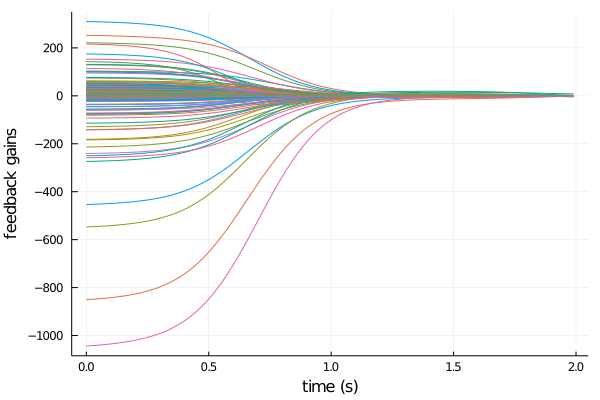

In [8]:
using Plots
Kmat = hcat(vec.(K)...);
plot(times[1:end-1], Kmat', legend=:none, xlabel="time (s)", ylabel="feedback gains")

It looks like they're starting to converge to some steady-state initial gain. Let's increase the length of our horizon and see what happens.

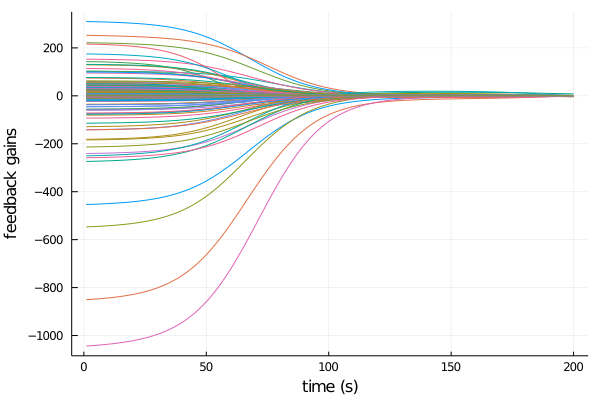

In [9]:
# TODO: Extend the horizon by at least 2x and save the new gains and cost-to-go in Kinf, Pinf (3 pts)
Kinf,Pinf = deepcopy(K), deepcopy(P)

# Plot the result
Kmat = hcat(vec.(Kinf)...);
plot(Kmat', legend=:none, xlabel="time (s)", ylabel="feedback gains")

You should be able to see that they're definitely converging to some steady-state initial value. This value is usually referred to as the "infinite horizon" gain, and is very useful in practice. It's common practice to use the associated cost-to-go matrix as the $Q_f$ weighting matrix in finite-horizon problems (we'll do this in Q3).

**TASK**: Tweak your controller code above so that if the `infinite_horizon` flag is true, it only uses the gains at the first time step. Then generate a new controller, `ctrl_inf` that only uses the infinite gain.

With both the finite and infinite-horizon controllers defined, let's see how they do on the system.

$$
P = Q + A^T PA − A^T PB(R + B^T PB)^{−1}B^T PA  \\
K = −(R + BT PB)^{−1}B^T PA
$$

In [10]:
# TODO: create the infinite-horizon controller (3 pts)
ctrl_inf = LQRController(K,xeq,ueq,tf, true);

## Part (d): Stability Analysis (3 pts)
Before we simulate, it's always a good idea to check the stability of our system. Evaluate the stability using the infinite-horizon gain and

In [11]:
# TASK: compute the stability of our original uncontrolled system
#       i.e. norm of largest eigenvalue
stability0 = maximum(norm.(eigvals(A)))

println("uncontrolled system:", stability0)

# TASK: compute the stability of our new, controlled system
stability = maximum(norm.(eigvals(A-B*K[1])))
println("controlled system:", stability)
@test stability0 > 1
@test stability < 1

uncontrolled system:1.6211732948555122
controlled system:0.9908540220945097


Test Passed

## Part (e): Simulate the Quadruped (5 pts)
Let's now put it all together and stabilize the quadruped.

In [12]:
# TASK: complete the simulator code (5 pts)
"""
    simulate(model, x0, controller; dt, tf, mvis)

Simulate the quadruped, starting from initial state `x0` and using `controller` to stabilize the system.

# Keyword Arguments
* `tf`: total simulation time
* `dt`: simulation time step
* `mvis`: if passed in, use the `MechanismVisualizer` to visualize the simulation while it's running
"""
function simulate(model::UnitreeA1, x0, controller; dt=0.05, tf=1.0, mvis=nothing)
    # some initialization
    time = range(0, tf, step=dt)
    n,m = state_dim(model), control_dim(model) 
    N = Int(round(tf/dt)) + 1
    X = [@SVector zeros(n) for k = 1:N] 
    U = [@SVector zeros(m) for k = 1:N-1] 
    
    # set the initial state
    X[1] = x0

    for k = 1:length(time) - 1
        # TODO: simulate the system with feedback
        U[k] = get_control(controller, X[k], time[k])
        
        k1 = dynamics(model, X[k]             , U[k])
        k2 = dynamics(model, X[k] + 0.5 * dt * k1, U[k])
        k3 = dynamics(model, X[k] + 0.5 * dt * k2, U[k])
        k4 = dynamics(model, X[k] +       dt * k3, U[k])
        X[k+1] = X[k] + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        
        # visualization code
        if !isnothing(mvis)
            set_configuration!(mvis, X[k+1][1:14])
            sleep(dt)
        end
    end
    return X,U,time
end

simulate

In [13]:
mvis = initialize_visualizer(model)
render(mvis);

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\Administrator\.julia\packages\MeshCat\GlCMx\src\visualizer.jl:73


In [14]:
# Perturb the initial condition
x_init = copy(xeq)
x_init[18] -= 0.1
x_init[19] -= 0.05

-0.05

In [15]:
# Finite Horizon
X,U,time = simulate(model, x_init, ctrl, dt=dt, tf=tf);
visualize!(mvis, model, time[end], X)  # send the trajectory to the visualizer

In [16]:
# Infinite horizon
Xinf,Uinf,time = simulate(model, x_init, ctrl_inf, dt=dt, tf=tf);
visualize!(mvis, model, time[end], Xinf)  # send the trajectory to the visualizer

Let's take a look some plots.

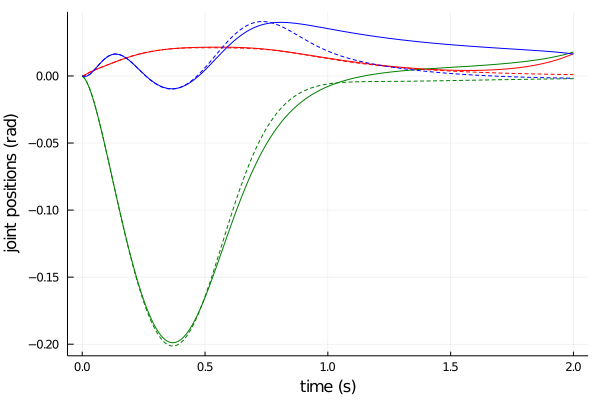

In [17]:
# Plot the response
c = [:red :green :blue]
dX = [x - xeq for x in X]
plot(times,dX,inds=3:5, legend=:none, xlabel="time (s)", ylabel="joint positions (rad)", c=c)
dX2 = [x - xeq for x in Xinf]
plot!(times, dX2, inds=3:5, legend=:none, colors=1:12, ls=:dash, c=c)

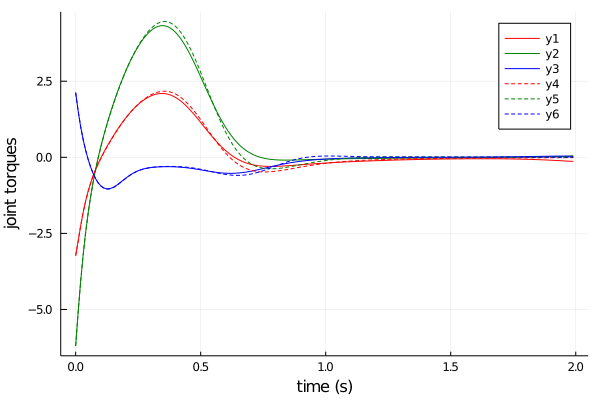

In [18]:
dU = [u - ueq for u in U]
plot(times[1:end-1], dU, inds=1:3, xlabel="time (s)", ylabel="joint torques", c=c)
dU2 = [u - ueq for u in Uinf]
plot!(times[1:end-1], dU2, inds=1:3, ls=:dash, c=c)

## Tests

In [19]:
run_tests();

Part c: Test Failed at C:\Users\Administrator\Documents\GitHub\16-745-hw2\test\q1.jl:31
  Expression: length(Kinf) >= 2 * length(K)
   Evaluated: 200 >= 400
Stacktrace:
 [1] top-level scope at C:\Users\Administrator\Documents\GitHub\16-745-hw2\test\q1.jl:31
 [2] top-level scope at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Test\src\Test.jl:1119
 [3] top-level scope at C:\Users\Administrator\Documents\GitHub\16-745-hw2\test\q1.jl:31
 [4] top-level scope at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.5\Test\src\Test.jl:1119
 [5] top-level scope at C:\Users\Administrator\Documents\GitHub\16-745-hw2\test\q1.jl:5
Part c: Test Failed at C:\Users\Administrator\Documents\GitHub\16-745-hw2\test\q1.jl:32
  Expression: ≈(Kinf[1], data["Kinf"], rtol = 0.001)
   Evaluated: [-453.38810094566105 49.50301180213451 … -0.07317842365239276 -0.29010963413288965; -850.3275974097979 216.13949621609027 … 0.06468956756733851 -0.4316914285810487; … ; 48.804707207671

LoadError: LoadError: [91mSome tests did not pass: 19 passed, 4 failed, 0 errored, 0 broken.[39m
in expression starting at C:\Users\Administrator\Documents\GitHub\16-745-hw2\test\q1.jl:4